## Delivery Duration Prediction

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

__Start:__ the time consumer submits the order `(created_at)` to
<br>
__End:__ when the order will be delivered to the consumer `(actual_delivery_time)`

#### My Approach

The dataset comes with two other predicted values: `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration`. The missing piece is the amount of time the order spends in the store. In addition to generic feature engineering, I will be creating separate order 'prep_time' statistics tables/dataframes to simulate gold fact tables in a database or features from a feature store (i.e. Feather, Feast) that would in turn live in a data lake.

This is a fairly popular exercise so it is possible to derive performance objectives. My goal is to produce a feature set and model that has a test RMSE of less than 1200 seconds and a test MAE of less than 600 seconds, with a stretch goal of 600 seconds for the test RMSE. For reference, the best models publically available produce a test RMSE around 980 - 1000 seconds.

Since an error of 20 minutes is impractical, I will split up the model based on the quantiles of an important and/or strongly correlated feature to see if I can build a model, or models, for the majority of the markets that will pass cross-validation and return a more reasonable test RMSE. 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
import xgboost

In [2]:
np.random.seed(42)

In [7]:
## note that the number of non-null store_id values is less than the number of non-null 
# store_primary category values. We can probably fill in most of the missing values via inference

## there are also stores with multiple store_primary_category values. Such stores might be 'ghost kitchens',
# and need to be backfilled appropriately
# TODO #1 write function to downfill NaN store_primary_category values

def fillNulls_store_category(historical_data:pd.DataFrame) -> pd.DataFrame:
    store_id_list = historical_data['store_id'].unique().tolist()
    store_id_cat = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() for store_id in store_id_list}
    historical_data['clean_store_primary_category']
    try:
        for x in store_id_list:
            historical_data['clean_store_primary_category'] = historical_data.store_id.apply(store_id_cat.values[0])
    except Exception as ee:
        raise ee
    return historical_data


In [3]:
## update types
## create target variable
def addFeatures_durations(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
        historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
        ## calculate delivery duration
        historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
        ## estimated time spent outside the store/not on order preparation
        historical_data['est_time_non-prep'] = historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration']
    except Exception as ex:
        raise ex
    return historical_data

In [60]:
def createBaseline(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
    historical_data = addFeatures_durations(historical_data=historical_data)
    try:
        baseline_data = historical_data[['store_id','actual_total_delivery_duration']]
        baseline_data = baseline_data.dropna()
        baseline_data = pd.merge(
            left=baseline_data,
            right=baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean,np.std]),
            how='inner',
            on='store_id'
        )
        baseline_data['z-score'] = (baseline_data['actual_total_delivery_duration'] - baseline_data['mean']) / baseline_data['std']
        baseline_data = baseline_data.loc[(baseline_data['z-score'] <=3) & (baseline_data['z-score'] >= -3)]
        baseline_avgs = baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean])
        baseline_data = pd.merge(
            left=historical_data[['store_id','actual_total_delivery_duration']].dropna(),
            right=baseline_avgs,
            on='store_id'
        )
        baseline_MAE = mean_absolute_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'])
        baseline_RMSE = mean_squared_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'],squared=False)
    except Exception as ex:
        raise ex
    return {'baseline_MAE:':baseline_MAE,'baseline_RMSE:':baseline_RMSE}

In [4]:
## TODO #4 create estimated prep time features that are anchored to stores and/or categories -- DONE
# the est_time_prep feature depends on the actual delivery datetime, which can't be provided to a model
# BUT a set of values derived from historical data can be given to a model on demand

def addFeatures_store_prep_stats(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
## returns a separate dataframe with the min, max, median and mean and standard deviation of the est_prep_time_per_item for each store_id
    try:
        historical_data = addFeatures_durations(historical_data=historical_data)
        ## calculate the amount of time (in seconds) the order spends in the store, then divide by the total number of items in the order
        historical_data['est_time_prep_per_item'] = (historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']) / historical_data['total_items']
        historical_data = historical_data[historical_data['est_time_prep_per_item'] > 0]
        store_prep_stats_df = historical_data[['store_id','est_time_prep_per_item']].groupby('store_id').est_time_prep_per_item.aggregate([np.mean,np.std])
        ## calculate z-score
        store_prep_facts_df = pd.merge(
            left=store_prep_stats_df.reset_index(),
            right=historical_data[['store_id','est_time_prep_per_item']],
            how='inner',
            on='store_id'
        )
        store_prep_facts_df['z_score'] = (store_prep_facts_df['est_time_prep_per_item'] - store_prep_facts_df['mean']) / store_prep_facts_df['std']
        ## drop outliers
        store_prep_stats_df = store_prep_facts_df.loc[(store_prep_facts_df['z_score'] <=3) & (store_prep_facts_df['z_score'] >= -3)]
        store_prep_stats_df = store_prep_stats_df.drop(columns=['mean','std'])
        store_prep_stats_df = store_prep_stats_df.groupby('store_id').est_time_prep_per_item.aggregate(['min','max','median',np.mean,np.std])
        store_prep_stats_df = store_prep_stats_df.add_prefix('store_est_time_prep_per_item_')
    except Exception as ex:
        raise ex
    return store_prep_stats_df

def addFeatures_category_prep_stats(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
## returns a separate dataframe with the min,max, median, mean and standard deviation for each category
    try:
        historical_data = addFeatures_durations(historical_data=historical_data)
        ## calculate the amount of time (in seconds) the order spends in the store, then divide by the total number of items in the order
        historical_data['est_time_prep_per_item'] = (historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']) / historical_data['total_items']
        historical_data = historical_data[historical_data['est_time_prep_per_item'] > 0]
        category_prep_stats_df = historical_data[['clean_store_primary_category','est_time_prep_per_item']].groupby('clean_store_primary_category').est_time_prep_per_item.aggregate([np.mean,np.std])
        ## calculate z-score
        category_prep_facts_df = pd.merge(
            left=category_prep_stats_df.reset_index(),
            right=historical_data[['created_at','clean_store_primary_category','est_time_prep_per_item']],
            how='inner',
            on='clean_store_primary_category'
        )
        category_prep_facts_df['z_score'] = (category_prep_facts_df['est_time_prep_per_item'] - category_prep_facts_df['mean']) / category_prep_facts_df['std']
        ## drop outliers
        category_prep_stats_df = category_prep_facts_df.loc[(category_prep_facts_df['z_score'] <= 3) & (category_prep_facts_df['z_score'] >= -3)]
        category_prep_stats_df = category_prep_stats_df.drop(columns=['mean','std','created_at'])
        category_prep_stats_df = category_prep_stats_df.groupby('clean_store_primary_category').est_time_prep_per_item.aggregate(['min','max','median',np.mean,np.std])
        category_prep_stats_df = category_prep_stats_df.add_prefix('category_est_time_prep_per_item_')
    except Exception as ex:
        raise ex
    return category_prep_stats_df

In [5]:
## add time of day features

def addFeatures_time_of_day(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_hour_of_day'] = historical_data['created_at'].dt.hour
        historical_data['created_day_of_week'] = historical_data['created_at'].dt.day_of_week
    except Exception as ex:
        raise ex
    return historical_data

In [6]:
## add ratio features
def addFeatures_ratios(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['available_dashers'] = historical_data['total_onshift_dashers'] - historical_data['total_busy_dashers']
        historical_data['busy_to_onshift'] = historical_data['total_onshift_dashers'] / historical_data['total_busy_dashers']
        historical_data['busy_to_onshift'].replace(to_replace=[np.inf,-np.inf],value=historical_data['total_onshift_dashers'][1],inplace=True)
        historical_data['busy_to_outstanding'] = historical_data['total_busy_dashers'] / historical_data['total_outstanding_orders']
        historical_data['busy_to_outstanding'].replace(to_replace=[np.inf,-np.inf,np.nan],value=0,inplace=True)
        historical_data['onshift_to_outstanding'] = historical_data['total_onshift_dashers'] / historical_data['total_outstanding_orders']
        historical_data['onshift_to_outstanding'].replace([np.inf,-np.inf],0,inplace=True)
    except Exception as ex:
        raise ex
    return historical_data

In [7]:
## add dummies for categories
def addFeatures_dummies(historical_data:pd.DataFrame,dummy_column:str) -> pd.DataFrame:
    try:
        dumm = pd.get_dummies(historical_data[dummy_column],prefix=str(dummy_column + '_'),dtype=float)
        # concat dummies
        historical_data = pd.concat([historical_data,dumm],axis=1)
        historical_data = historical_data.drop(columns=[dummy_column])
    except Exception as ex:
        raise ex
    return historical_data

In [8]:
historical_data = pd.read_csv('historical_data.csv')


store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
# fill null values
historical_data["clean_store_primary_category"] = historical_data.store_id.apply(fill)

## build store, category prep time statistics DataFrames
store_prep_stats_df = addFeatures_store_prep_stats(historical_data=historical_data)
category_prep_stats_df = addFeatures_category_prep_stats(historical_data=historical_data)
## build the training dataset using the functions above
train_df = addFeatures_durations(historical_data=historical_data)
train_df = addFeatures_ratios(historical_data=train_df)
train_df = addFeatures_time_of_day(historical_data=train_df)
## merge store, category prep stats DataFrames with train_df
train_df = pd.merge(
    left=train_df,
    right=store_prep_stats_df.reset_index(),
    how='inner',
    on='store_id'
)
train_df = pd.merge(
    left=train_df,
    right=category_prep_stats_df.reset_index(),
    how='inner',
    on='clean_store_primary_category'
)
## add total prep time estimations
train_df['store_est_median_total_prep_time'] = train_df['total_items'] * train_df['store_est_time_prep_per_item_median']
train_df['store_est_mean_total_prep_time'] = train_df['total_items'] * train_df['store_est_time_prep_per_item_mean']
## add dummy columns for clean_store_primary_category, market_id, order_protocol
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='clean_store_primary_category')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='market_id')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='order_protocol')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='created_hour_of_day')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='created_day_of_week')
# drop the native 'store_primary_category' column and all remaining non-feature columns, then do a headcheck
train_df.drop(columns=['store_primary_category','created_at','actual_delivery_time','store_id','est_time_prep_per_item'],inplace=True)
## drop NaN's
train_df.dropna(inplace=True)
train_df = train_df.astype("float32")

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,created_hour_of_day__21,created_hour_of_day__22,created_hour_of_day__23,created_day_of_week__0,created_day_of_week__1,created_day_of_week__2,created_day_of_week__3,created_day_of_week__4,created_day_of_week__5,created_day_of_week__6
0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,2.0,446.0,338.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
## identify feature pairs with high correlation
# this is something I borrowed from another notebook and I am not convinced about the methodology
# the idea is that you hand-remove features that have a low frequency and a high coefficient

def labelMaker_feature_pairs(train_df:pd.DataFrame) -> set:
    try:
        labeled_pairs = set()
        clmn = train_df.columns
        for i in range(0,train_df.shape[1]):
            for j in range(0,i+1):
                labeled_pairs.add((clmn[i],clmn[j]))
    except Exception as ex:
        raise ex
    return labeled_pairs

def calcAbsCorr_top_feature_pairs(train_df:pd.DataFrame,n:int) -> list:
    try:
        abs_corr = train_df.corr(method='pearson').abs().unstack()
        drop_labels = labelMaker_feature_pairs(train_df)
        abs_corr = abs_corr.drop(labels=drop_labels).sort_values(ascending=False)
    except Exception as ex:
        raise ex
    return abs_corr[0:n]

In [11]:
## check for multicollinearity

def calcVIF(feature_frame:pd.DataFrame,target_feature:str):
    try:
        feature_frame = add_constant(feature_frame)
        feature_list = feature_frame.drop(columns=[target_feature]).columns.to_list()
        vif_frame = pd.DataFrame()
        vif_frame['feature'] = feature_list
        vif_frame['VIF'] = [variance_inflation_factor(feature_frame[feature_list].values,i) for i in range(len(feature_list))]
    except Exception as ex:
        raise ex
    return vif_frame.sort_values(by=['VIF'],ascending=False).reset_index(drop=True)

def VIF_dim_reduction(feature_frame:pd.DataFrame,target_feature:str,vif_limit:int):
    vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
    try:
        ## drop nan columns from feature set, nan VIF values from base VIF table
        vif_table['VIF'].replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
        nan_list = vif_table[vif_table['VIF'].isnull()]['feature'].to_list()
        feature_frame = feature_frame.drop(columns=nan_list)
        vif_table = vif_table.set_index(vif_table.feature)
        vif_table = vif_table.drop(labels=nan_list).reset_index(drop=True)
        ## start
        multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
        while multicollinearity:
            lead_vif_feature = vif_table['feature'].values.tolist()[1]
            feature_frame = feature_frame.drop(columns=lead_vif_feature)
            vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
            multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
    except Exception as ex:
        raise ex
    return feature_frame,vif_table

In [12]:
## feature selection/dimensionality reduction with PCA
##TODO #2 make a class for PCA
##TODO #3 retain row numbers in scaler --DONE

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler = scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler = scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled,scaler

def transform_rmse_to_seconds(scaler,y_test,y_hat_scaled):
    try:
        y_hat_descaled = scaler.inverse_transform(y_hat_scaled.reshape(-1,1))
        rmse_descaled = mean_squared_error(y_pred=y_test,y_true=y_hat_descaled[:,0],squared=False)
    except Exception as ex:
        raise ex
    return y_hat_descaled,rmse_descaled

In [13]:
def PCAcalc_expl_var(x_train,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
# and a feature to component ratio to support automation of further dimensionality reduction
    pca = PCA()
    x_train_scaled = apply_standard_scaler(x_train)[0]
    try:
        pca = pca.fit(x_train_scaled)
        components = np.cumsum(pca.explained_variance_ratio_)
        components = [i for i in components if i <= target_expl_variance]
        feature_to_component_ratio = len(components)/x_train.shape[1]
    except Exception as ex:
        raise ex
    return components,feature_to_component_ratio

def PCAcalc_dim_reduction(x_train,x_test,desired_components:int):
## you know, dimensionality reduction
    pca = PCA(n_components=desired_components)
    x_train_scaled,x_test_scaled = apply_standard_scaler(x_train)[0],apply_standard_scaler(x_test)[0]
    try:
        pca = pca.fit(x_train_scaled)
        x_train_pca,x_test_pca = pca.transform(x_train_scaled),pca.transform(x_test_scaled)
    except Exception as ex:
        raise ex
    return x_train_pca,x_test_pca

### Feature Importance & Feature Selection

In [14]:
def calcRF_feature_importance(x_train,y_train) -> pd.DataFrame:
    feature_names = x_train.columns.to_list()
    feature_importance = {}
    model_forest = RandomForestRegressor(random_state=42)
    try:
        model_forest.fit(x_train,y_train)
        for feature,importance in zip(x_train.columns,model_forest.feature_importances_):
            feature_importance[feature] = importance
        importances = pd.DataFrame.from_dict(feature_importance,orient='index').rename(columns={0:'gini-importance'})
    except Exception as ex:
        raise ex
    return importances

In [15]:
VIF_features = VIF_dim_reduction(feature_frame=train_df,target_feature='actual_total_delivery_duration',vif_limit=20)[1]

c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195:

In [16]:
VIF_featureset = VIF_features.drop(VIF_features[VIF_features.feature == 'const'].index)
VIF_featureset = VIF_featureset['feature'].to_list()
VIF_featureset = VIF_featureset + ['actual_total_delivery_duration']
VIF_train_df = train_df[VIF_featureset]

In [17]:
vif_x_train,vif_x_test,vif_y_train,vif_y_test = build_train_test(dataset=VIF_train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

<AxesSubplot:>

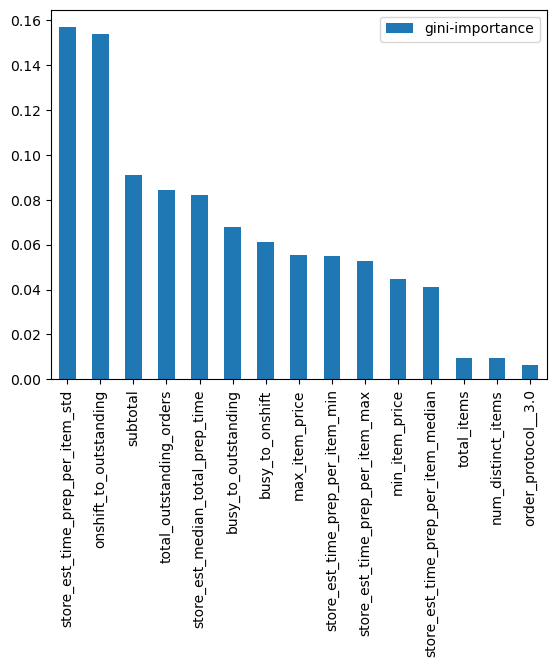

In [195]:
vif_importances = calcRF_feature_importance(x_train=vif_x_train,y_train=vif_y_train)
vif_importances.sort_values(by='gini-importance',ascending=False).head(15).plot(kind='bar',rot=90)

We need 15 features (out of 25 available) to explain 90 percent of the variance after VIF dimensionality reduction


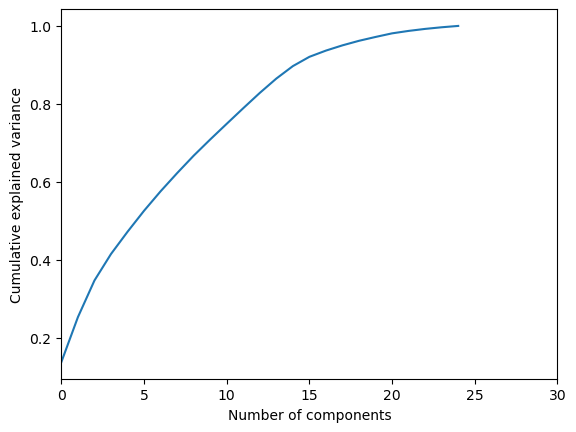

In [18]:
## how many features are needed to explain 90% of the variance?
print("We need " + str(len(PCAcalc_expl_var(x_train=vif_x_train,target_expl_variance=0.9)[0])) + " features (out of " + str(vif_x_train.shape[1]) + " available) to explain 90 percent of the variance after VIF dimensionality reduction")

vif_x_train_scaled = apply_standard_scaler(vif_x_train)[0]
pca = PCA().fit(vif_x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,30,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [33]:
## applicator function for ML methods

def applyMethod_make_regression(x_train,y_train,x_test,y_test,model):
    try:
        model.fit(x_train,y_train)
        ## train error
        y_hat_train = model.predict(x_train)
        train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
        train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
        ## test error
        y_hat_test = model.predict(x_test)
        test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
        test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
        eval_stats = {
            'train_RMSE:':train_RMSE,
            'train_MAE:':train_MAE,
            'test_RMSE:':test_RMSE,
            'test_MAE:':test_MAE
        }
        trained_model = model
    except Exception as ex:
        raise ex
    return trained_model,y_hat_test,eval_stats

In [65]:
def applyMethod_xgboost(x_train,y_train,x_test,y_test,reg_alpha:int,reg_lambda:int,eval_metric:str,random_state=42):
    try:
        model = xgboost.XGBRegressor(reg_alpha=reg_alpha,reg_lambda=reg_lambda,eval_metric=eval_metric,random_state=random_state).fit(x_train,y_train)
        ## train error
        y_hat_train = model.predict(x_train)
        train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
        train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
        ## test error
        y_hat_test = model.predict(x_test)
        test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
        test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
        eval_stats = {
            'train_RMSE:':train_RMSE,
            'train_MAE:':train_MAE,
            'test_RMSE:':test_RMSE,
            'test_MAE:':test_MAE
        }
        trained_model = model
    except Exception as ex:
        raise ex
    return trained_model,y_hat_test,eval_stats

In [35]:
xtrain,xtest,ytrain,ytest = build_train_test(dataset=VIF_train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

In [198]:
trained_xgbregressor = applyMethod_make_regression(x_train=xtrain,x_test=xtest,y_test=ytest,y_train=ytrain,model=xgboost.XGBRegressor())
trained_xgbregressor[2]


c:\Users\lukew\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'train_RMSE:': 862.523,
 'train_MAE:': 612.2747,
 'test_RMSE:': 1037.2075,
 'test_MAE:': 652.5748}

In [136]:
# does the first attempt at modeling improve on a baseline, average-derived model?
createBaseline(historical_data=historical_data)


{'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

In [94]:
yhat_train = trained_xgbregressor.predict(xtrain)

In [123]:
yhat_test = trained_xgbregressor.predict(xtest)

In [208]:
## join train absolute error with all features
pred_frame = xtrain.join(ytrain)
pred_frame['yhat_pred'] = yhat_train.reshape(-1,1)
## test_data['error'] = test_data['actual_total_delivery_duration'] - test_data['yhat_pred']
pred_frame['abs_error'] = abs(pred_frame['actual_total_delivery_duration'] - pred_frame['yhat_pred'])
full_feature_df_train = pd.merge(
    left = pred_frame[['abs_error']],
    right = train_df,
    how='left',
    left_index=True,
    right_index=True
    )
## join test absolute error with all features
pred_frame = xtest.join(ytest)
pred_frame['yhat_pred'] = yhat_test.reshape(-1,1)
## test_data['error'] = test_data['actual_total_delivery_duration'] - test_data['yhat_pred']
pred_frame['abs_error'] = abs(pred_frame['actual_total_delivery_duration'] - pred_frame['yhat_pred'])
full_feature_df_test = pd.merge(
    left = pred_frame[['abs_error']],
    right = train_df,
    how='left',
    left_index=True,
    right_index=True
    )
full_feature_df = pd.concat([full_feature_df_test,full_feature_df_train])

A single-model approach produces a long-tailed error distribution; 59.449416176595925% of the observations in the dataset have an absolute error of less than 900 seconds or twenty minutes.


<AxesSubplot:ylabel='Frequency'>

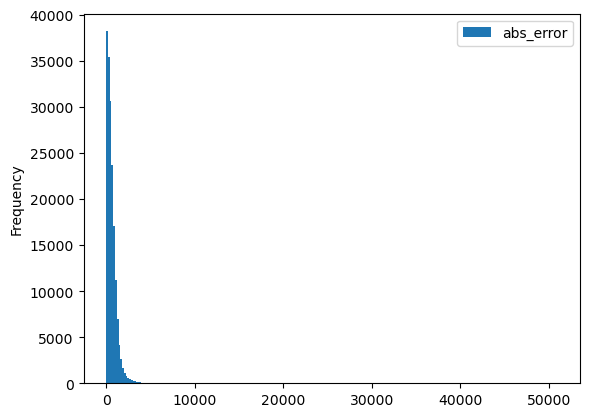

In [280]:
chixit = full_feature_df[['abs_error']]

print(
    "A single-model approach produces a long-tailed error distribution; "
    + str(((chixit[chixit['abs_error'] < 600].shape[0] / chixit.shape[0])*100)) + "%"
    + " of the observations in the dataset have an absolute error of less than 900 seconds or twenty minutes."
    )
chixit.plot.hist(bins=256)

<AxesSubplot:>

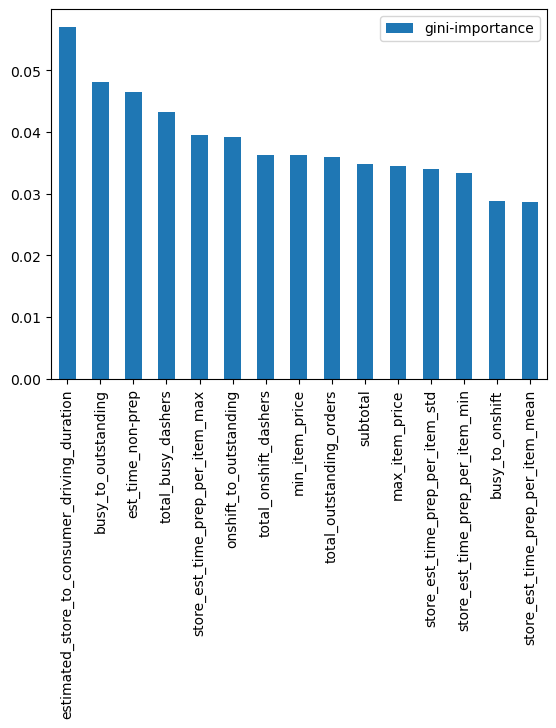

In [217]:
error_xtrain,error_xtest,error_ytrain,error_ytest = build_train_test(dataset=full_feature_df[full_feature_df['abs_error'] > 900],target_feature='abs_error',test_size=0.2)
error_importances = calcRF_feature_importance(x_train=error_xtrain,y_train=error_ytrain)
error_importances.sort_values(by='gini-importance',ascending=False).head(15).plot(kind='bar',rot=90)

In [281]:
tail_df = VIF_train_df.drop(
    labels=full_feature_df[full_feature_df['abs_error'] <= 600].index,
    axis=0
)
tail_xtrain,tail_xtest,tail_ytrain,tail_ytest = build_train_test(dataset=tail_df,target_feature='actual_total_delivery_duration',test_size=0.2)

body_df = VIF_train_df.drop(
    labels=full_feature_df[full_feature_df['abs_error'] > 600].index,
    axis=0
)
body_xtrain,body_xtest,body_ytrain,body_ytest = build_train_test(dataset=body_df,target_feature='actual_total_delivery_duration',test_size=0.2)

In [282]:
tail_model = applyMethod_make_regression(x_train=tail_xtrain,x_test=tail_xtest,y_train=tail_ytrain,y_test=tail_ytest,model=xgboost.XGBRegressor())
tail_model[2]

c:\Users\lukew\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'train_RMSE:': 1218.6412,
 'train_MAE:': 1009.03436,
 'test_RMSE:': 1474.7993,
 'test_MAE:': 1158.0519}

In [283]:
body_model = applyMethod_make_regression(x_train=body_xtrain,x_test=body_xtest,y_train=body_ytrain,y_test=body_ytest,model=xgboost.XGBRegressor())
body_model[2]

c:\Users\lukew\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'train_RMSE:': 330.0506,
 'train_MAE:': 274.84006,
 'test_RMSE:': 367.8758,
 'test_MAE:': 301.99106}

In [286]:
chezo = trained_xgbregressor[0].predict(xtest)


In [287]:
chirco = xtest.join(ytest)
chirco['pred'] = chezo.reshape(-1,1)
chirco['abs_error'] = abs(chirco['actual_total_delivery_duration'] - chirco['pred'])
chirco['abs_error'].mean()

652.5748901367188